#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import math
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_1176464/2250032840.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

/storage/phucpg/venv/v1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# !pip install efficientnet_pytorch
# !pip install pytorch-dpn-pretrained
from efficientnet_pytorch import EfficientNet
import torch.hub

##Define runtime

In [5]:
# !pip install ipython-autotime
%load_ext autotime

time: 867 µs (started: 2024-08-17 23:10:06 +07:00)


##Define GPU usage

In [6]:
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Available GPUs:
GPU 0: Tesla K80
GPU 1: Tesla K80
GPU 2: Tesla K80
GPU 3: Tesla K80
GPU 4: Tesla K80
GPU 5: Tesla K80
GPU 6: Tesla K80
GPU 7: Tesla K80
time: 160 ms (started: 2024-08-17 23:10:06 +07:00)


In [7]:
# Set the GPU device
gpu_index = 1  # Change the index for each file (0 to 7)
if gpu_index < torch.cuda.device_count():
    torch.cuda.set_device(gpu_index)
    device = torch.device(f"cuda:{gpu_index}")
    print(f"Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
else:
    print(f"Invalid GPU index: {gpu_index}. Please choose an index between 0 and {torch.cuda.device_count() - 1}.")


Using GPU 1: Tesla K80
time: 1.85 ms (started: 2024-08-17 23:10:06 +07:00)


#DATA PREPARATION

##Get and Import dataset

In [8]:
data_dir = '../data/ISIC_2019'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

time: 2.21 ms (started: 2024-08-17 23:10:06 +07:00)


###Meta-data

In [9]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

image  age_approx anatom_site_general    lesion_id     sex
0      ISIC_0000000        55.0      anterior torso          NaN  female
1      ISIC_0000001        30.0      anterior torso          NaN  female
2      ISIC_0000002        60.0     upper extremity          NaN  female
3      ISIC_0000003        30.0     upper extremity          NaN    male
4      ISIC_0000004        80.0     posterior torso          NaN    male
...             ...         ...                 ...          ...     ...
25326  ISIC_0073247        85.0           head/neck  BCN_0003925  female
25327  ISIC_0073248        65.0      anterior torso  BCN_0001819    male
25328  ISIC_0073249        70.0     lower extremity  BCN_0001085    male
25329  ISIC_0073251        55.0         palms/soles  BCN_0002083  female
25330  ISIC_0073254        50.0     upper extremity  BCN_0001079    male

[25331 rows x 5 columns]

time: 84 ms (started: 2024-08-17 23:10:06 +07:00)


In [10]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0      ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1      ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2      ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3      ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4      ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
...             ...  ...  ...  ...  ...  ...  ...   ...  ...  ...
25326  ISIC_0073247  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25327  ISIC_0073248  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
25328  ISIC_0073249  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25329  ISIC_0073251  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25330  ISIC_0073254  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0

[25331 rows x 10 columns]

time: 79.1 ms (started: 2024-08-17 23:10:07 +07:00)


In [11]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

image  age_approx anatom_site_general     sex
0     ISIC_0034321        60.0                 NaN  female
1     ISIC_0034322        70.0      anterior torso    male
2     ISIC_0034323        70.0     lower extremity    male
3     ISIC_0034324        70.0     lower extremity    male
4     ISIC_0034325        30.0     upper extremity  female
...            ...         ...                 ...     ...
8233  ISIC_0073236        75.0      anterior torso    male
8234  ISIC_0073243        65.0     lower extremity    male
8235  ISIC_0073250        30.0      anterior torso  female
8236  ISIC_0073252        85.0           head/neck  female
8237  ISIC_0073253        70.0      anterior torso    male

[8238 rows x 4 columns]

time: 33.5 ms (started: 2024-08-17 23:10:07 +07:00)


###Meta-data information

In [12]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 23.3 ms (started: 2024-08-17 23:10:07 +07:00)


In [13]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 9.91 ms (started: 2024-08-17 23:10:07 +07:00)


In [14]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 8.87 ms (started: 2024-08-17 23:10:07 +07:00)


##DATA PREPROCESSING

###Original data information

In [15]:
train_metadata.info()
print()
# train_metadata.head()
print(train_metadata.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 20.1 ms (started: 2024-08-17 23:10:07 +07:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [16]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 77.8 ms (started: 2024-08-17 23:10:07 +07:00)


In [17]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 60.7 ms (started: 2024-08-17 23:10:07 +07:00)


In [18]:
train_metadata_pp.info()
print()
train_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB



Image_Id  Age Region_Of_Disease     Lesion_Id     Sex  \
1459   ISIC_0012653_downsampled   50   posterior torso  MSK4_0011169  female   
1460   ISIC_0012654_downsampled   30   lower extremity  MSK4_0011170  female   
1461   ISIC_0012655_downsampled   35   upper extremity  MSK4_0011171  female   
1462   ISIC_0012656_downsampled   45   posterior torso  MSK4_0011172    male   
1463   ISIC_0012657_downsampled   20   upper extremity  MSK4_0011173  female   
...                         ...  ...               ...           ...     ...   
25326              ISIC_0073247   85         head/neck   BCN_0003925  female   
25327              ISIC_0073248   65    anterior torso   BCN_0001819    male   
25328              ISIC_0073249   70   lower extremity   BCN_0001085    male   
25329              ISIC_0073251   55       palms/soles   BCN_0002083  female   
25330              ISIC_0073254   50   upper extremity   BCN_0001079    male   

      Disease_Type  Presence                      Diagnosis  
1459            NV       1.0               Melanocytic Nevi  
1460            NV       1.0               Melanocytic Nevi  
1461            NV       1.0               Melanocytic Nevi  
1462            NV       1.0               Melanocytic Nevi  
1463            NV       1.0               Melanocytic Nevi  
...            ...       ...                            ...  
25326          BCC       1.0           Basal Cell Carcinoma  
25327          BKL       1.0  Benign Keratosis-Like Lesions  
25328          MEL       1.0                       Melanoma  
25329           NV       1.0               Melanocytic Nevi  
25330          BKL       1.0  Benign Keratosis-Like Lesions  

[21311 rows x 8 columns]

time: 55.3 ms (started: 2024-08-17 23:10:07 +07:00)


###Get images data

finish preprocessing

In [19]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

Image_Id  Age Region_Of_Disease     Lesion_Id     Sex  \
1459   ISIC_0012653_downsampled   50   posterior torso  MSK4_0011169  female   
1460   ISIC_0012654_downsampled   30   lower extremity  MSK4_0011170  female   
1461   ISIC_0012655_downsampled   35   upper extremity  MSK4_0011171  female   
1462   ISIC_0012656_downsampled   45   posterior torso  MSK4_0011172    male   
1463   ISIC_0012657_downsampled   20   upper extremity  MSK4_0011173  female   
...                         ...  ...               ...           ...     ...   
25326              ISIC_0073247   85         head/neck   BCN_0003925  female   
25327              ISIC_0073248   65    anterior torso   BCN_0001819    male   
25328              ISIC_0073249   70   lower extremity   BCN_0001085    male   
25329              ISIC_0073251   55       palms/soles   BCN_0002083  female   
25330              ISIC_0073254   50   upper extremity   BCN_0001079    male   

      Disease_Type  Presence                      Diagnosis  \
1459            NV       1.0               Melanocytic Nevi   
1460            NV       1.0               Melanocytic Nevi   
1461            NV       1.0               Melanocytic Nevi   
1462            NV       1.0               Melanocytic Nevi   
1463            NV       1.0               Melanocytic Nevi   
...            ...       ...                            ...   
25326          BCC       1.0           Basal Cell Carcinoma   
25327          BKL       1.0  Benign Keratosis-Like Lesions   
25328          MEL       1.0                       Melanoma   
25329           NV       1.0               Melanocytic Nevi   
25330          BKL       1.0  Benign Keratosis-Like Lesions   

                                              Image_path  
1459   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1460   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1461   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1462   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
1463   ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
...                                                  ...  
25326  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25327  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25328  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25329  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  
25330  ../data/ISIC_2019/ISIC_2019_Training_Input/ISI...  

[21311 rows x 9 columns]

time: 9.36 s (started: 2024-08-17 23:10:07 +07:00)


In [20]:
# train_metadata_pp = train_metadata_pp.sample(n=5000, random_state=42) # remove this line for full dataset
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
 8   Image_path         21311 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.6+ MB
time: 19 ms (started: 2024-08-17 23:10:16 +07:00)


###Correctting image paths

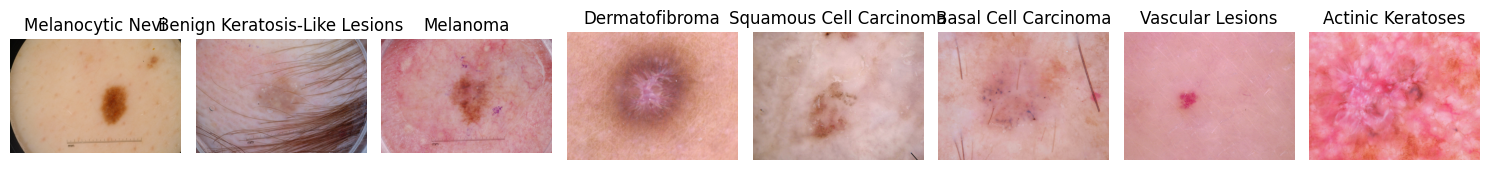

time: 30.4 s (started: 2024-08-17 23:10:16 +07:00)


In [21]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Prepare data for training process

###Label Encoder

In [22]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 7.61 ms (started: 2024-08-17 23:10:47 +07:00)


###Augment and transfrom dataset

In [23]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 18.7 ms (started: 2024-08-17 23:10:47 +07:00)


###Split data

In [24]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 17048
Validation set size: 2131
Test set size: 2132
time: 25.1 ms (started: 2024-08-17 23:10:47 +07:00)


###Balancing dataset

In [25]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 62368
time: 59 ms (started: 2024-08-17 23:10:47 +07:00)


###Custom dataset class

In [26]:
#  make easily load and preprocess dataset -> compatible with PyTorch’s data loading utilities.
class LoadedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Diagnosis_Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = LoadedDataset(train_df_resampled, transform=transform)
val_dataset = LoadedDataset(val_df, transform=transform)
test_dataset = LoadedDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

# Example of iterating through the dataloader and printing results
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    print(f"Labels: {labels}")

    print("Label Mapping:", label_mapping)
    print("Unique Labels in Dataset:", train_metadata_pp['Diagnosis_Label'].unique())

    break  # Print only the first batch

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])
Labels: tensor([5, 3, 0, 6, 1, 0, 6, 7, 0, 2, 4, 6, 4, 6, 7, 1, 4, 1, 6, 0, 1, 6, 3, 4,
        5, 3, 7, 7, 6, 1, 5, 7])
Label Mapping: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
Unique Labels in Dataset: [4 2 5 3 6 1 7 0]
time: 3.21 s (started: 2024-08-17 23:10:47 +07:00)


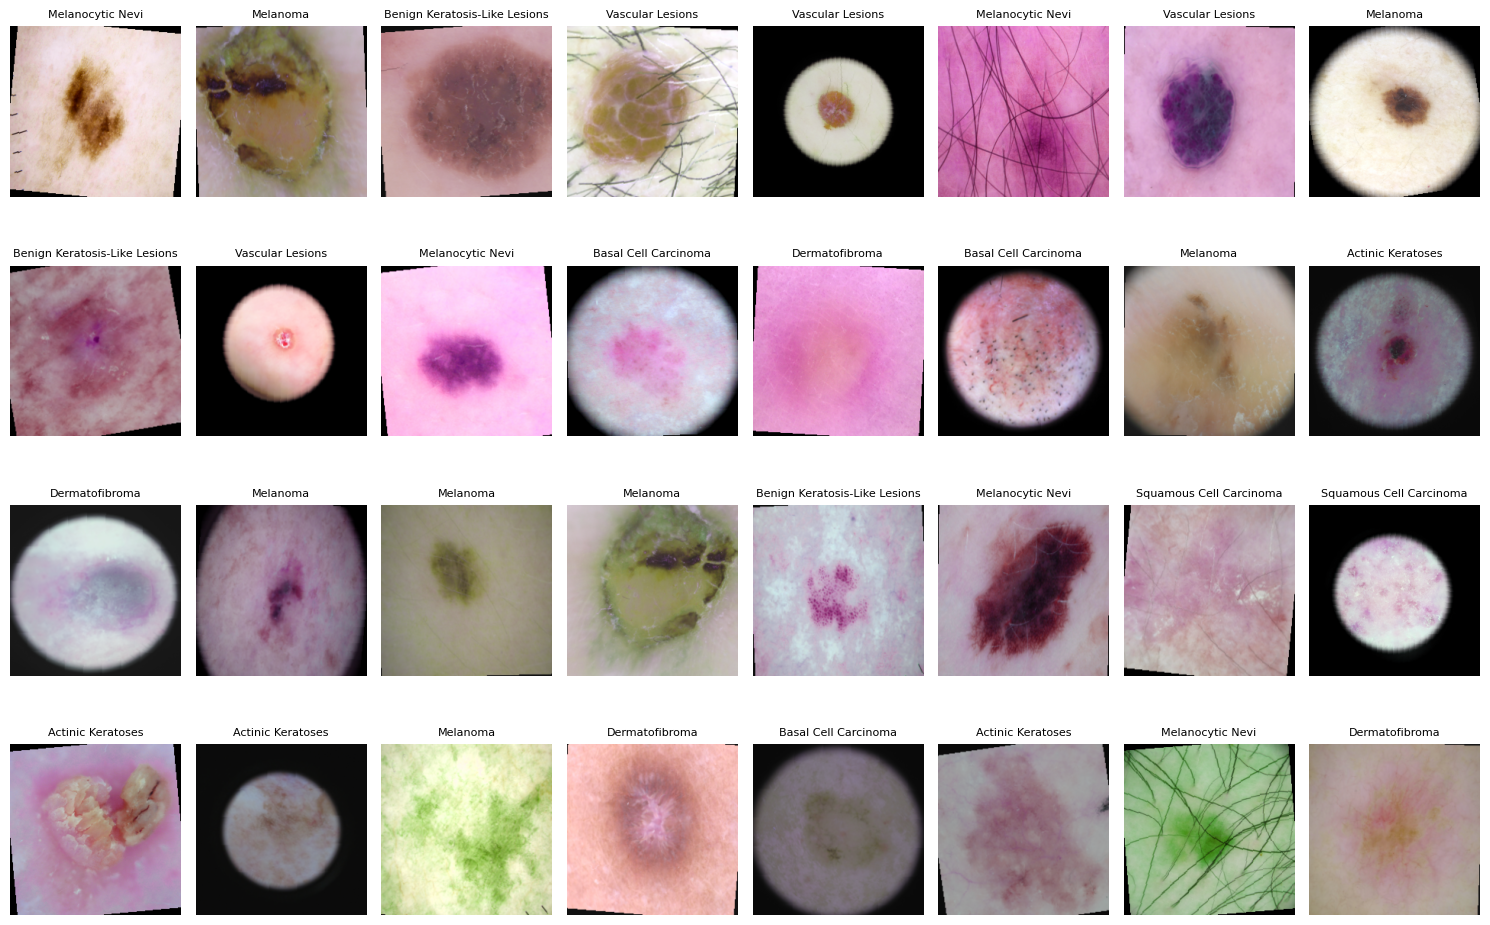

time: 6.69 s (started: 2024-08-17 23:10:50 +07:00)


In [27]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    num_images = len(images)
    num_cols = 8
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        plt.imshow(img)
        plt.axis('off')

        label = labels[i].item()
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)


##Model functionalities

###Construct models

In [28]:
def create_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'densenet201':
        model = models.densenet201(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'efficientnet-b5':
        model = EfficientNet.from_pretrained('efficientnet-b5')
        num_ftrs = model._fc.in_features
        model._fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'resnext50':
        model = models.resnext50_32x4d(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout with 50% probability
            nn.Linear(num_ftrs, num_classes)
        )
        model.num_classes = num_classes
    elif model_name == 'shufflenet_v2_x1_0':
        model = models.shufflenet_v2_x1_0(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'dpn68':
        model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn68', pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == 'customCNN':
        model = CustomCNN(num_classes)
    else:
        raise ValueError("Invalid model name. Choose from 'resnet101', 'densenet201', 'efficientnet-b5', 'resnext50_32x4d', 'shufflenetv2', 'dpn68', or 'customCNN'.")
    return model


time: 2.37 ms (started: 2024-08-17 23:10:57 +07:00)


###Load trained models

In [29]:
def load_saved_models(save_dir, model_names, num_classes):
    models = {}
    accuracies = {}
    losses = {}

    for model_name in model_names:
        model_path = os.path.join(save_dir, f'{model_name}_best.pth')
        checkpoint = torch.load(model_path)
        
        model = create_model(model_name, num_classes)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        
        models[model_name] = model
        accuracies[model_name] = checkpoint['val_acc']
        losses[model_name] = checkpoint['val_loss']
        print(f"Loaded {model_name} with validation accuracy: {checkpoint['val_acc']:.2f}% and validation loss: {checkpoint['val_loss']:.4f}")
    
    return models, accuracies, losses

# Define the model names and number of classes
model_names = ['resnet50', 'densenet201', 'shufflenet_v2_x1_0']
num_classes = 8
save_dir = 'best_model'

# Load the models, their accuracies, and losses
models, accuracies, losses = load_saved_models(save_dir, model_names, num_classes)

Loaded resnet50 with validation accuracy: 3.94% and validation loss: 2.0814
Loaded densenet201 with validation accuracy: 28.30% and validation loss: 1.4504
Loaded shufflenet_v2_x1_0 with validation accuracy: 71.33% and validation loss: 0.8170
time: 17 s (started: 2024-08-17 23:10:57 +07:00)


####Calculating the weights of each contributor model

In [41]:
# def weighted_voting_ensemble(models, accuracies, dataloader, threshold=0.5):
#     all_preds = []
#     all_labels = []
    
#     # Calculate the total sum of accuracies for normalization
#     total_accuracy = sum(accuracies.values())
    
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images = images.to(device)
#             labels = labels.to(device)
            
#             # Initialize an array to store the weighted sum of probabilities
#             weighted_sum = np.zeros((images.size(0), num_classes))
            
#             for model_name, model in models.items():
#                 outputs = model(images)
#                 probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                
#                 # Calculate the weight for the current model
#                 weight = accuracies[model_name] / total_accuracy
#                 weighted_sum += probabilities * weight
            
#             # Normalize the weighted sum to get the final probabilities
#             final_probabilities = weighted_sum
#             max_probs = np.max(final_probabilities, axis=1)
#             predicted = np.argmax(final_probabilities, axis=1)
#             confident_preds = (max_probs >= threshold).astype(int) * predicted
            
#             all_preds.extend(confident_preds)
#             all_labels.extend(labels.cpu().numpy())
    
#     # Print the weights of each model after processing the dataloader
#     for model_name, accuracy in accuracies.items():
#         weight = accuracy / total_accuracy
#         print(f"Model: {model_name}, Weight: {weight:.4f}")
    
#     return all_preds, all_labels

# # Use the ensemble model to make predictions on the test set
# ensemble_preds, ensemble_labels = weighted_voting_ensemble(models, accuracies, test_loader)

# # Calculate the accuracy of the ensemble model
# ensemble_accuracy = accuracy_score(ensemble_labels, ensemble_preds)
# print(f'Ensemble Model Accuracy: {ensemble_accuracy:.2f}%')

# # Print the classification report
# print(classification_report(ensemble_labels, ensemble_preds, target_names=label_mapping.keys()))

time: 1.8 ms (started: 2024-08-17 22:46:03 +07:00)


In [30]:
def weighted_voting_ensemble(models, accuracies, losses, dataloader, threshold=0.5):
    all_preds = []
    all_labels = []
    
    # Normalize accuracies and losses
    max_accuracy = max(accuracies.values())
    min_loss = min(losses.values())
    
    normalized_accuracies = {k: v / max_accuracy for k, v in accuracies.items()}
    normalized_losses = {k: min_loss / v for k, v in losses.items()}
    
    # Calculate the total sum of combined weights for normalization
    total_weight = sum(normalized_accuracies[k] + normalized_losses[k] for k in models.keys())
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Initialize an array to store the weighted sum of probabilities
            weighted_sum = np.zeros((images.size(0), num_classes))
            
            for model_name, model in models.items():
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                
                # Calculate the combined weight for the current model
                weight = (normalized_accuracies[model_name] + normalized_losses[model_name]) / total_weight
                weighted_sum += probabilities * weight
            
            # Normalize the weighted sum to get the final probabilities
            final_probabilities = weighted_sum
            max_probs = np.max(final_probabilities, axis=1)
            predicted = np.argmax(final_probabilities, axis=1)
            confident_preds = (max_probs >= threshold).astype(int) * predicted
            
            all_preds.extend(confident_preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Print the weights of each model after processing the dataloader
    for model_name in models.keys():
        weight = (normalized_accuracies[model_name] + normalized_losses[model_name]) / total_weight
        print(f"Model: {model_name}, Weight: {weight:.4f}")
    
    return all_preds, all_labels

# Use the ensemble model to make predictions on the test set
ensemble_preds, ensemble_labels = weighted_voting_ensemble(models, accuracies, losses, test_loader)

# Calculate the accuracy of the ensemble model
ensemble_accuracy = accuracy_score(ensemble_labels, ensemble_preds) * 100
print(f'Ensemble Model Accuracy: {ensemble_accuracy:.2f}%')

# Print the classification report
print(classification_report(ensemble_labels, ensemble_preds, target_names=label_mapping.keys()))


Model: resnet50, Weight: 0.1314
Model: densenet201, Weight: 0.2817
Model: shufflenet_v2_x1_0, Weight: 0.5869
Ensemble Model Accuracy: 58.02%
                               precision    recall  f1-score   support

            Actinic Keratoses       0.10      0.81      0.17        85
         Basal Cell Carcinoma       0.83      0.65      0.73       325
Benign Keratosis-Like Lesions       0.65      0.50      0.56       230
               Dermatofibroma       0.91      0.43      0.59        23
             Melanocytic Nevi       0.89      0.64      0.75       975
                     Melanoma       0.78      0.39      0.52       410
      Squamous Cell Carcinoma       0.74      0.47      0.57        62
             Vascular Lesions       0.85      0.77      0.81        22

                     accuracy                           0.58      2132
                    macro avg       0.72      0.58      0.59      2132
                 weighted avg       0.80      0.58      0.65      2132

time

###Visualization

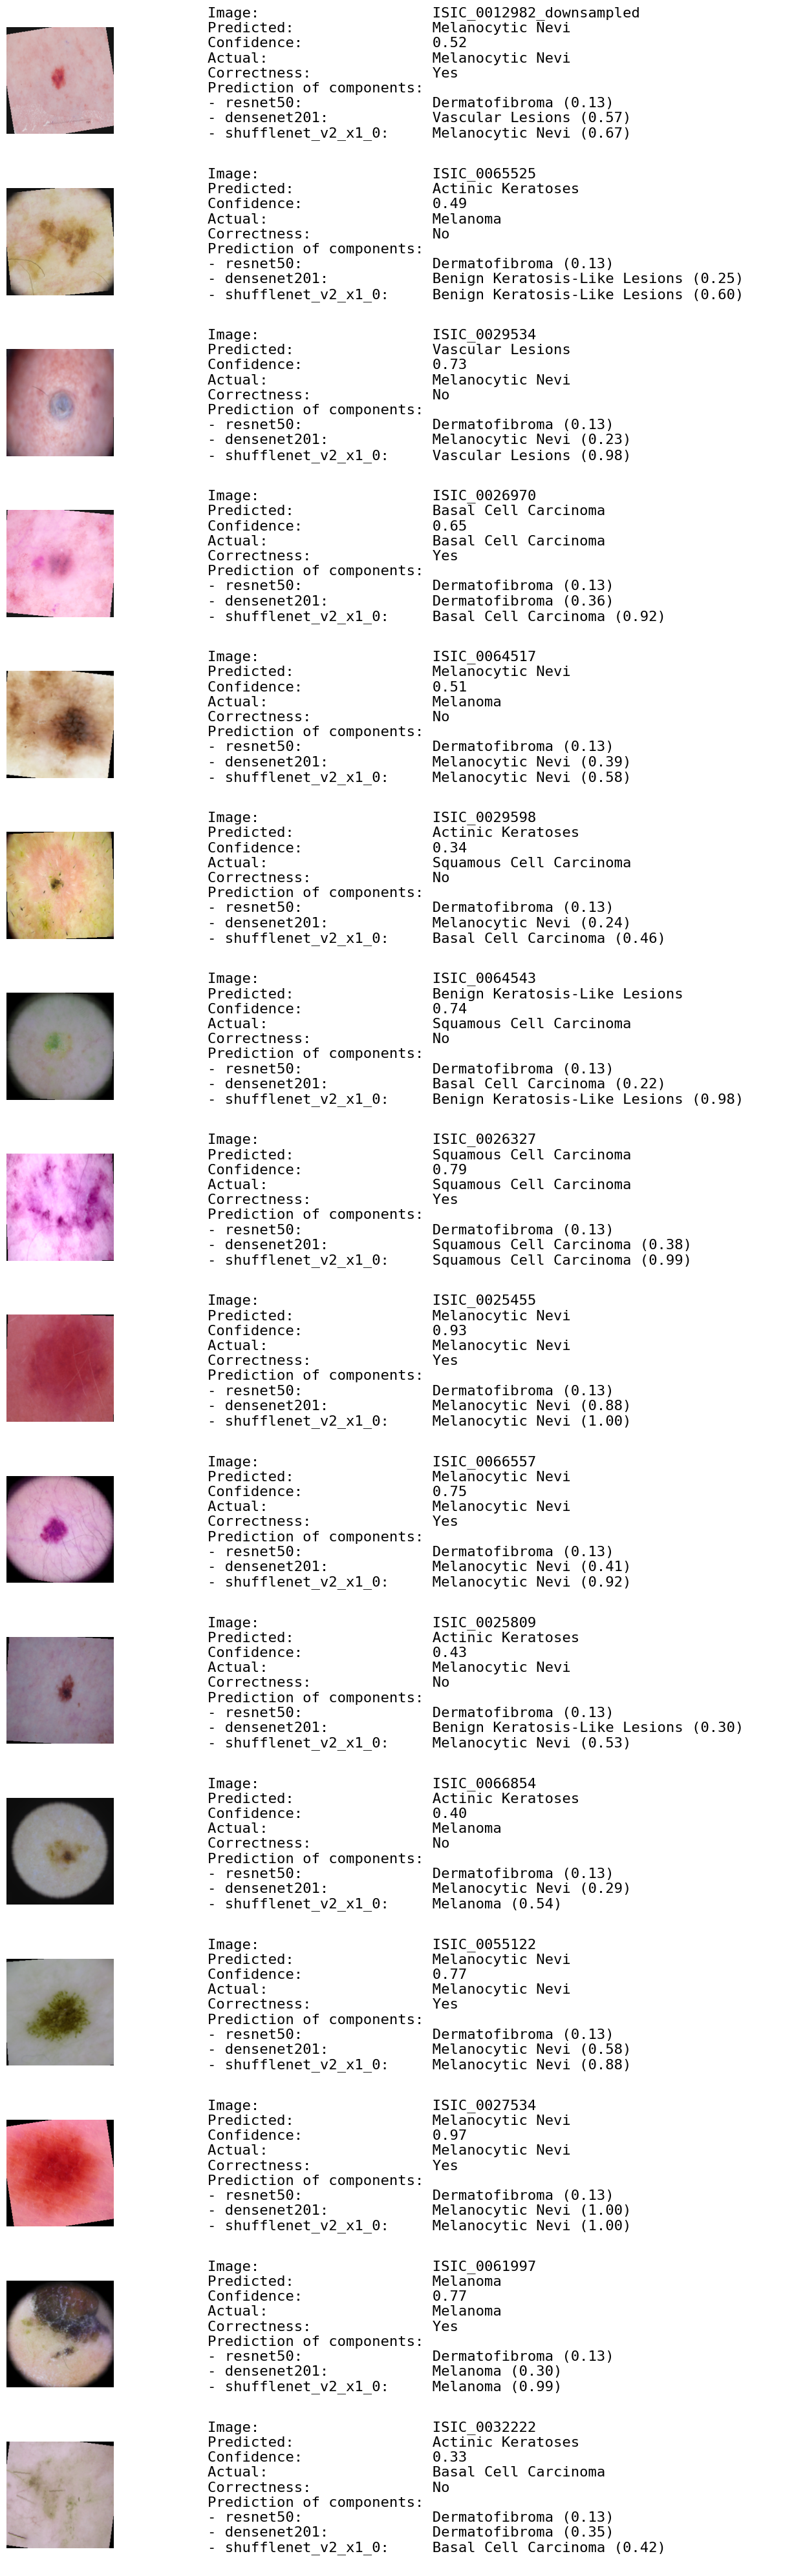

time: 7.31 s (started: 2024-08-17 23:07:30 +07:00)


In [47]:
def visualize_ensemble_predictions(models, accuracies, dataloader, label_mapping, num_images=16, threshold=0.5):
    models = {name: model.eval() for name, model in models.items()}
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 2, figsize=(18, num_images * 2.5))  # Increase the figure size

    total_accuracy = sum(accuracies.values())

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            weighted_sum = np.zeros((images.size(0), len(label_mapping)))
            model_predictions = {name: [] for name in models.keys()}

            for model_name, model in models.items():
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                weight = accuracies[model_name] / total_accuracy
                weighted_sum += probabilities * weight
                model_predictions[model_name] = probabilities

            final_probabilities = weighted_sum
            max_probs = np.max(final_probabilities, axis=1)
            preds = np.argmax(final_probabilities, axis=1)
            confident_preds = (max_probs >= threshold).astype(int) * preds

            for j in range(images.size()[0]):
                if images_so_far == num_images:
                    plt.tight_layout()
                    return
                
                ax_img = axes[images_so_far, 0]
                ax_info = axes[images_so_far, 1]
                ax_img.axis('off')
                ax_info.axis('off')

                # Display the image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                ax_img.imshow(img)

                # Display the information
                image_name = dataloader.dataset.dataframe.iloc[j]['Image_Id']
                predicted_label = list(label_mapping.keys())[confident_preds[j]]
                actual_label = list(label_mapping.keys())[labels[j]]
                correctness = "Yes" if predicted_label == actual_label else "No"
                info_text = (f'{"Image:":<25} {image_name}\n'
                             f'{"Predicted:":<25} {predicted_label}\n'
                             f'{"Confidence:":<25} {max_probs[j]:.2f}\n'
                             f'{"Actual:":<25} {actual_label}\n'
                             f'{"Correctness:":<25} {correctness}\n'
                             f'{"Prediction of components:":<25}\n')
                
                for model_name, probs in model_predictions.items():
                    model_pred = np.argmax(probs[j])
                    model_prob = probs[j][model_pred]
                    info_text += f'{"- " + model_name + ":":<25} {list(label_mapping.keys())[model_pred]} ({model_prob:.2f})\n'
                
                ax_info.text(0, 0.5, info_text, fontsize=16, verticalalignment='center', family='monospace')  # Use fixed-width font

                images_so_far += 1

    plt.tight_layout()

visualize_ensemble_predictions(models, accuracies, val_loader, label_mapping)

TEST PREDICTING THE MODEL

In [36]:
test_metadata.info()
print()
test_metadata
# print(test_metadata.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB



image  age_approx anatom_site_general     sex
0     ISIC_0034321        60.0                 NaN  female
1     ISIC_0034322        70.0      anterior torso    male
2     ISIC_0034323        70.0     lower extremity    male
3     ISIC_0034324        70.0     lower extremity    male
4     ISIC_0034325        30.0     upper extremity  female
...            ...         ...                 ...     ...
8233  ISIC_0073236        75.0      anterior torso    male
8234  ISIC_0073243        65.0     lower extremity    male
8235  ISIC_0073250        30.0      anterior torso  female
8236  ISIC_0073252        85.0           head/neck  female
8237  ISIC_0073253        70.0      anterior torso    male

[8238 rows x 4 columns]

time: 30.1 ms (started: 2024-08-17 19:30:57 +07:00)


In [38]:
# Removing duplicate rows
test_metadata_pp = test_metadata.drop_duplicates()

# Removing rows with missing values
test_metadata_pp = test_metadata_pp.dropna()

# Fixing column names
test_metadata_pp = test_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'sex': 'Sex'
})

# Replace missing values in 'age' column with median age
median_age = test_metadata_pp['Age'].median()
test_metadata_pp['Age'] = test_metadata_pp['Age'].fillna(median_age)

# Convert the Age column to integers
test_metadata_pp['Age'] = test_metadata_pp['Age'].astype(int)

# Add a placeholder Diagnosis column
test_metadata_pp['Diagnosis'] = 'Unknown'

test_metadata_pp

Image_Id  Age Region_Of_Disease     Sex Diagnosis
1     ISIC_0034322   70    anterior torso    male   Unknown
2     ISIC_0034323   70   lower extremity    male   Unknown
3     ISIC_0034324   70   lower extremity    male   Unknown
4     ISIC_0034325   30   upper extremity  female   Unknown
5     ISIC_0034326   80         head/neck    male   Unknown
...            ...  ...               ...     ...       ...
8233  ISIC_0073236   75    anterior torso    male   Unknown
8234  ISIC_0073243   65   lower extremity    male   Unknown
8235  ISIC_0073250   30    anterior torso  female   Unknown
8236  ISIC_0073252   85         head/neck  female   Unknown
8237  ISIC_0073253   70    anterior torso    male   Unknown

[7537 rows x 5 columns]

time: 29.7 ms (started: 2024-08-17 19:32:54 +07:00)


In [39]:
# Load test images
def load_test_images(test_metadata, image_dir):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
    test_metadata['Image_path'] = test_metadata['Image_Id'].map(image_path_dict)
    return test_metadata

# Predict with ensemble model
def predict_with_ensemble(models, accuracies, test_metadata, transform, label_encoder, threshold=0.5):
    # Add the Diagnosis_Label column to the test metadata
    test_metadata['Diagnosis_Label'] = label_encoder.transform(test_metadata['Diagnosis'])
    
    test_dataset = LoadedDataset(test_metadata, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    all_preds = []
    all_labels = []
    
    total_accuracy = sum(accuracies.values())
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            weighted_sum = np.zeros((images.size(0), len(label_mapping)))
            
            for model_name, model in models.items():
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                
                weight = accuracies[model_name] / total_accuracy
                weighted_sum += probabilities * weight
            
            final_probabilities = weighted_sum
            max_probs = np.max(final_probabilities, axis=1)
            predicted = np.argmax(final_probabilities, axis=1)
            confident_preds = (max_probs >= threshold).astype(int) * predicted
            
            all_preds.extend(confident_preds)
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

time: 3.02 ms (started: 2024-08-17 19:34:13 +07:00)


In [40]:
# Load test images
test_metadata_pp = load_test_images(test_metadata_pp, test_input_dir)

test_metadata_pp

# # Predict with ensemble model
# ensemble_preds, ensemble_labels = predict_with_ensemble(models, accuracies, test_metadata_pp, transform, label_encoder)

# # Calculate accuracy
# ensemble_accuracy = accuracy_score(ensemble_labels, ensemble_preds)
# print(f'Ensemble Model Accuracy on Test Set: {ensemble_accuracy:.2f}%')

# # Print classification report
# print(classification_report(ensemble_labels, ensemble_preds, target_names=label_mapping.keys()))

Image_Id  Age Region_Of_Disease     Sex Diagnosis  \
1     ISIC_0034322   70    anterior torso    male   Unknown   
2     ISIC_0034323   70   lower extremity    male   Unknown   
3     ISIC_0034324   70   lower extremity    male   Unknown   
4     ISIC_0034325   30   upper extremity  female   Unknown   
5     ISIC_0034326   80         head/neck    male   Unknown   
...            ...  ...               ...     ...       ...   
8233  ISIC_0073236   75    anterior torso    male   Unknown   
8234  ISIC_0073243   65   lower extremity    male   Unknown   
8235  ISIC_0073250   30    anterior torso  female   Unknown   
8236  ISIC_0073252   85         head/neck  female   Unknown   
8237  ISIC_0073253   70    anterior torso    male   Unknown   

                                             Image_path  
1     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
2     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
3     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
4     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
5     ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
...                                                 ...  
8233  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
8234  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
8235  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
8236  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  
8237  ../data/ISIC_2019/ISIC_2019_Test_Input/ISIC_00...  

[7537 rows x 6 columns]

time: 3.17 s (started: 2024-08-17 19:34:14 +07:00)


In [ ]:
# Define the model names and number of classes
model_names = ['resnet50', 'densenet201', 'shufflenet_v2_x1_0']
num_classes = 8
save_dir = 'best_model'

# Load the models, their accuracies, and losses
models, accuracies, losses = load_saved_models(save_dir, model_names, num_classes)